<a href="https://colab.research.google.com/github/synsense/snn-workshop-amld-2022/blob/master/4.%20Auditory%20Processing/SNN_with_temporal_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4 : Training a Spiking Neural Networks for a temporal memory task

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Hannah Bos, Philipp Weidel, Mina Khoei

**Estimated timing**: ...

In this tutorial, we show how to train and deploy an SNN to our neuromorphic chip Xylo. We cover the entire pipeline starting from defining the task, showing how to design and train the SNN ,and eventually how to map and simulate the SNN on Xylo. 
<br/><br/>
The SNN is trained on a temporal task. The model has to classify a stimulus depending on the context-stimulus that is shown in the past. This simple delay task can be solved with an SNN with one hidden layer of neurons with synaptic kernels. The model learns how to store a trace of the context-stimulus in the synaptic kernels with large time constants.

<br/><br/>

![](https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/4.%20Auditory%20Processing/diagrams/setup.jpg)

## Setup

We use the following software packages to train the SNN and simulate it on the Xylo chip.

*   [Rockpool](https://rockpool.ai) is our main simulator for designing and training low-power SNNs. The training is build on [PyTorch](https://pytorch.org) and [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). Rockpool can [map an SNN to the architecture of the Xylo chip](https://rockpool.ai/devices/xylo-overview.html) and [simulate an upstream analog front end AFE](https://rockpool.ai/devices/analog-frontend-example.html) that preprocesses the signal before it is inserted into Xylo.
*   [XyloSim](https://pypi.org/project/xylosim/) is a simulation toolbox which simulates an SNN that runs on the Xylo chip.
* [samna](https://pypi.org/project/samna/) ...



In [1]:
!pip install samna
!pip install xylosim
!pip install git+https://gitlab.com/synsense/rockpool.git
!pip install torch
!pip install torchmetrics

     |████████████████████████████████| 280 kB 12.2 MB/s 
     |████████████████████████████████| 211 kB 41.9 MB/s 
  Cloning https://gitlab.com/synsense/rockpool.git to /tmp/pip-req-build-dd5rsixd
  Running command git clone -q https://gitlab.com/synsense/rockpool.git /tmp/pip-req-build-dd5rsixd
  Created wheel for rockpool: filename=rockpool-2.4.dev0-py3-none-any.whl size=386923 sha256=97d69f7500f2015dfbc5713d4d349fe2794351b147659596e06964ce0a6e9344
  Stored in directory: /tmp/pip-ephem-wheel-cache-gnb9t2kb/wheels/88/12/6a/e1999c6eef826d670141773fd2a66326cc4d2be5bdc27913ec
Successfully built rockpool
     |████████████████████████████████| 398 kB 11.9 MB/s 


## The data set

In [2]:
#@title dataloader
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(1235)

class DelayTask:
    '''
        Channel A (chA) and channel (chB) represent two time-dependent values.
        This class defines a rate profile for each stimulus class and generates
        size_dataset samples by drawing random number of spikes per time step 
        from the rate profile.
        Channel A either generates a pulse at tA = offset_start remains silent.
        Channel B always generates a pulse start at tB = tA + delay.

        The two output neurons represent the classes
        A     + B -> class 0
        not A + B -> class 1

        :param pulse_width: pulse-width in number of time steps
        :param signal_strength: mean and std of pulse in spikes per time steps
                               [[meanA, meanB], [stdA, stdB]] 
        :param noise_strength: mean and std of noise in spikes per time steps
                               [mean, std]
        :param delay: number of time steps between start of pulse A and 
                      start of pulse B
        :param offset_start: time steps added before beginning of pulse A
        :param offset_stop: time steps added after end of pulse B
        :param max_spikes_per_dt: maximal number of spikes oer time step, 
                                  the signal is clipped to that values
        : param size_dataset: total number of samples
        :return:
      '''
    def __init__(self, pulse_width=10, signal_strength=[[7.0, 7.0], [1.0, 1.0]], 
                 noise_strength=[1.0, 1.0], delay=20, offset_start=10, 
                 offset_stop=10, max_spikes_per_dt=15, size_dataset=1000):

        self.mean_values, self.std_values = signal_strength
        self.mean_noise, self.std_noise = noise_strength
        self.max_spikes_per_dt = max_spikes_per_dt
        self.tA = offset_start
        self.tB = self.tA + delay  # start of pulse representing second value
        self.pulse_width = pulse_width
        self.delay = delay
        self.duration = self.tB + self.pulse_width + offset_stop
        self.n_classes = 2
        self.classes = [i for i in range(self.n_classes)]
        # channels 0, 1 represent input values 0, 1
        self.n_channels = 2
        self.size_dataset = size_dataset
        self.create_rate_profiles()

    def create_rate_profiles(self):
        profile_shape = (self.n_classes, self.duration, self.n_channels)
        # rate profiles for background noise
        self.rate_profiles_noise = np.ones(profile_shape) * self.mean_noise
        # rate profile for signals
        self.rate_profiles_signal = np.zeros(profile_shape) 
        # add pulse to channels
        pulseA = self.mean_values[0] * np.ones(self.pulse_width)
        pulseB = self.mean_values[1] * np.ones(self.pulse_width)
        self.rate_profiles_signal[0, self.tA: self.tA + self.pulse_width, 0] += pulseA
        self.rate_profiles_signal[0, self.tB: self.tB + self.pulse_width, 1] += pulseB
        self.rate_profiles_signal[1, self.tB: self.tB + self.pulse_width, 1] += pulseB

    def __getitem__(self, item):
        label = np.random.randint(0, self.n_classes)
        signal = np.random.normal(self.rate_profiles_noise[label], self.std_noise)
        # add signale to each channel
        signal[:, 0] += np.random.normal(self.rate_profiles_signal[label][:, 0], self.std_values[0])
        signal[:, 1] += np.random.normal(self.rate_profiles_signal[label][:, 1], self.std_values[1])
        signal = np.round(signal.clip(0, self.max_spikes_per_dt))
        return signal, np.array([label])

    def __len__(self):
        return self.size_dataset


def create_dataloaders(params_delay_task={}, size_dataset=10000, batch_size=100, 
                       partitions=['train', 'val', 'test'],
                       percentages=[0.8, 0.1, 0.1], num_workers=1):

    datasets = []
    for p in percentages:
        params_delay_task['size_dataset'] = int(size_dataset*p)
        datasets.append(DelayTask(**params_delay_task))

    dataloaders = []
    for i, dataset in enumerate(datasets):
        if partitions[i] in ['val', 'test']:
            shuffle_data = False
        else:
            shuffle_data = True
        # need to drop last batch if it does not have full batch_size since the sinabs neurons are initialized with
        # batch_size
        dataloaders.append(DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data,
                                      num_workers=num_workers, drop_last=True))
    return dataloaders

### Explore the delay task dataset 

In [3]:
#@title *Exercise* part I
# Part I: Visualize rate profiles for the two stimulus types
import matplotlib.pyplot as plt

# TODO: pick values for the parameters of the DelayTask class and instantiate 
# a DelayTask object

# TODO: visualize the rate profiles of the signal, the noise and the total 
# input for the two classes


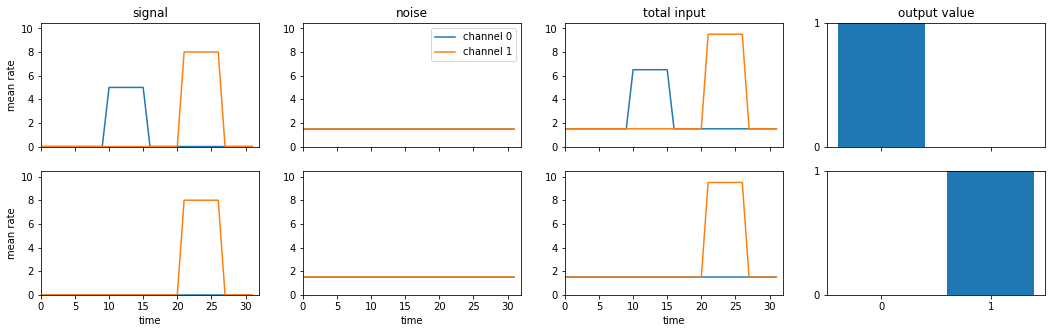

In [4]:
#@title *Solution* part I
import matplotlib.pyplot as plt

# define parameter
params_data = {'pulse_width': 6, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 11, 'signal_strength': [[5.0, 8.0], [1.0, 1.0]], 
               'noise_strength': [1.5, 1.0]}

# get delay_task object
delay_task = DelayTask(**params_data)

# plot rate profiles
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(18, 5))
for i in range(2):
    ax[i][0].plot(delay_task.rate_profiles_signal[i, :, 0], label='channel 0')
    ax[i][0].plot(delay_task.rate_profiles_signal[i, :, 1], label='channel 1')
    ax[i][1].plot(delay_task.rate_profiles_noise[i, :, 0], label='channel 0')
    ax[i][1].plot(delay_task.rate_profiles_noise[i, :, 1], label='channel 1')
    input_class_0 = delay_task.rate_profiles_signal[i, :, 0] 
    input_class_0 += delay_task.rate_profiles_noise[i, :, 0]
    ax[i][2].plot(input_class_0)
    input_class_1 = delay_task.rate_profiles_signal[i, :, 1]
    input_class_1 += delay_task.rate_profiles_noise[i, :, 1]
    ax[i][2].plot(input_class_1)
    ax[i][3].get_shared_x_axes().remove(ax[i][3])
    ax[i][3].get_shared_y_axes().remove(ax[i][3])
    weight = [0, 0]
    weight[i] = 1
    ax[i][3].bar([0, 1], weight)
    ax[i][0].set_ylabel('mean rate')
    for j in range(3):
        ax[i][j].set_xlim([0, delay_task.duration])
        ymax = (delay_task.mean_values[1]+delay_task.mean_noise)*1.1
        ax[i][j].set_ylim([0, ymax])
        ax[0][j].set_xticklabels([])
        ax[1][j].set_xlabel('time')
    ax[i][3].set_xlim([-0.5, 1.5])
    ax[i][3].set_ylim([0, 1])
    ax[i][3].set_xticks([0, 1])
    ax[i][3].set_xticklabels([])
    ax[i][3].set_yticks([0, 1])
ax[0][0].set_title('signal')
ax[0][1].set_title('noise')
ax[0][2].set_title('total input')
ax[0][3].set_title('output value')
ax[1][3].set_xticklabels([0, 1])
ax[0][1].legend();

In [5]:
#@title *Exercise* part II
# Part II: visualize discrete/spiking realization of the stimuli

# TODO: visualize some samples of the input for each class. You can get the 
# samples either from the DelayTask class or by using the create_dataloaders() 
# function

# parameter for delay task
params_data = {'pulse_width': 20, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 50, 'signal_strength': [[1.5, 1.5], [0.1, 0.1]], 
               'noise_strength': [0.15, 0.15]}

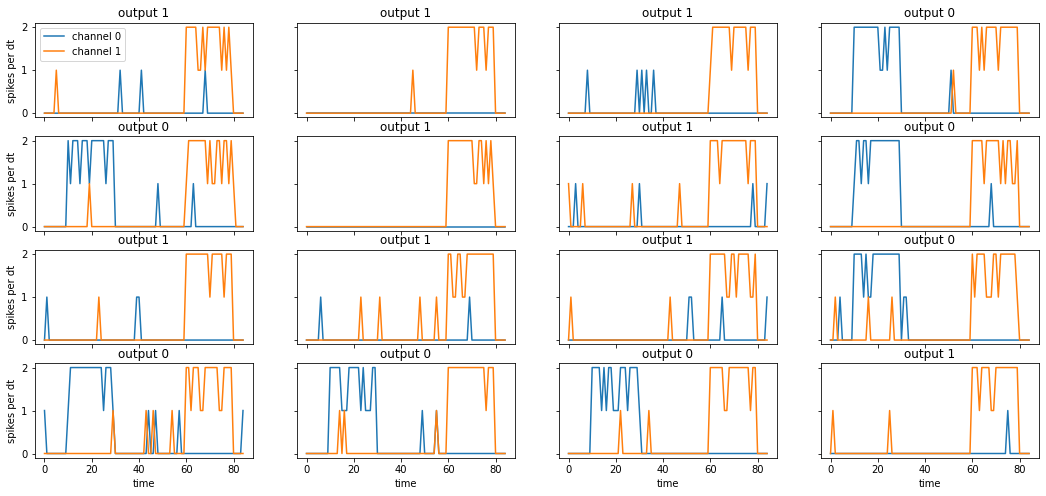

In [6]:
#@title *Solution* part II
# Part II: visualize discrete/spiking realization of the stimuli

# parameter for delay task
params_data = {'pulse_width': 20, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 50, 'signal_strength': [[1.5, 1.5], [0.1, 0.1]], 
               'noise_strength': [0.15, 0.15]}

# get delay_task object
delay_task = DelayTask(**params_data)

# plot input samples
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(18, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        signal, label = delay_task.__getitem__(0)
        ax[i][j].plot(signal[:, 0], label='channel 0')
        ax[i][j].plot(signal[:, 1], label='channel 1')
        ax[i][j].set_title('output ' + str(label[0]))
        ax[3][j].set_xlabel('time')
    ax[i][0].set_ylabel('spikes per dt')
ax[0][0].legend();

## SynNet: an SNN with synpatic currents

### Build the model

In [7]:
#@title *Exercise*
from rockpool.nn.modules import TorchModule, LinearTorch, LIFBitshiftTorch
from rockpool.parameters import Constant
from rockpool.nn.combinators import Sequential
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential

from typing import List

# some parameters that we need for the entire tutorial
n_classes = 2
threshold_hidden = 0.4
threshold_readout_for_training = 70.0

# TODO: define a function that returns the SynNet model

def define_SynNet(
    n_classes: int = n_classes,     
    n_channels: int = 2,       
    tau_syn_hidden: List = [2e-3],
    tau_mem: float = 2e-3,
    tau_syn_out: float = 2e-3,
    threshold: float = threshold_hidden,
    neuron_model: TorchModule = LIFBitshiftTorch,
    max_spikes_per_dt: int = 31,
    max_spikes_per_dt_out: int = 1,
    dt: float = 1e-3
    ):
        """
        Args:
            :param int n_classes:            number of output classes
            :param int n_channels:           number of input channels
            :param List tau_syn_hidden:      list of synaptic time constants of 
                                             hidden layer neurons 
            :param float tau_syn_out:        synaptic time constants of output
                                             neurons 
            :param float tau_mem:            membrane time constant of all 
                                             neurons
            :param float threshold:          threshold of all neurons
            :param TorchModule neuron_model: neuron model of all neurons
            :param max_spikes_per_dt:        maximum number of spikes per time
                                             step of all neurons apart from 
                                             output neurons
            :param max_spikes_per_dt_out:    maximum number of spikes per time
                                             step of output neurons
            :param float dt:                 one time step is seconds
        """   
        
        n_hidden = len(tau_syn_hidden)
        tau_syn_hidden = torch.tensor(tau_syn_hidden)
        thresholds = Constant([threshold for i in range(n_hidden)])

        # TODO: initialize a linear weight layer that maps the input to the
        # hidden layer (set the bias to False, has_bias=False)
        # lin = ...

        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn_hidden)
        # this ensures that initially all synpatic kernel contribute euqally
        # with torch.no_grad():
        #   lin.weight.data = ...

        # TODO: initialize the neuron model for the hidden neurons
        # - set the shape (n_hidden inputs are maped to n_hidden neurons)
        # - set the thresholds, Hint: use the vector defined above
        # - set the synaptic time constants and thresholds as arrays (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set the membrane time constant, bias as scalars (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        # spk = ...

        # TODO: initialize a linear weight layer that maps the activity of the 
        # hidden layer to the output neurons (set the bias to False)
        # lin_out = ...

        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn)
        # with torch.no_grad():
        #   lin_out.weight.data = ...

        # TODO: initialize the neuron model for the output neurons
        # - set the shape (n_classes inputs are maped to n_classes neurons)
        # - set the synaptic time constant, membrane time constant, bias as 
        #   scalars (make sure that they are wrapped by Constant() such that 
        #   they are not trained)
        # - set the threshold high (threshold_out_for_training) and constant 
        #   (we don't want the output neurons to spike in the training loop) 
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        # spk_out = ...

        # TODO: use the Sequential combinator to stack the layers
        # snn = ..

        # return snn

In [8]:
#@title *Solution*
from rockpool.nn.modules import TorchModule, LinearTorch, LIFBitshiftTorch
from rockpool.parameters import Constant
from rockpool.nn.combinators import Sequential
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential

from typing import List

def define_SynNet(
    n_classes: int = n_classes,     
    n_channels: int = 2,       
    tau_syn_hidden: List = [2e-3],
    tau_mem: float = 2e-3,
    tau_syn_out: float = 2e-3,
    threshold: float = threshold_hidden,
    neuron_model: TorchModule = LIFBitshiftTorch,
    max_spikes_per_dt: int = 31,
    max_spikes_per_dt_out: int = 1,
    dt: float = 1e-3
    ):
        """
        Args:
            :param int n_classes:            number of output classes
            :param int n_channels:           number of input channels
            :param List tau_syn_hidden:      list of synaptic time constants of 
                                             hidden layer neurons 
            :param float tau_syn_out:        synaptic time constants of output
                                             neurons 
            :param float tau_mem:            membrane time constant of all 
                                             neurons
            :param float threshold:          threshold of all neurons
            :param TorchModule neuron_model: neuron model of all neurons
            :param max_spikes_per_dt:        maximum number of spikes per time
                                             step of all neurons apart from 
                                             output neurons
            :param max_spikes_per_dt_out:    maximum number of spikes per time
                                             step of output neurons
            :param float dt:                 one time step is seconds
        """   
        
        n_hidden = len(tau_syn_hidden)
        tau_syn_hidden = torch.tensor(tau_syn_hidden)
        thresholds = Constant([threshold for i in range(n_hidden)])

        # initialize a linear layer that maps the input to the hidden layer
        lin = LinearTorch(shape=(n_channels, n_hidden), has_bias=False)

        # scale the weights to the hidden neurons by the synpatic time constants
        # this ensures that initially all synpatic kernel contribute euqally
        with torch.no_grad():
          lin.weight.data = lin.weight.data * dt / tau_syn_hidden

        # initialize the hidden neurons
        spk = neuron_model(shape=(n_hidden, n_hidden), 
                           tau_mem=Constant(tau_mem),
                           tau_syn=Constant(tau_syn_hidden),
                           bias=Constant(0.0),
                           threshold=thresholds,
                           spike_generation_fn=PeriodicExponential,
                           dt=dt,
                           max_spikes_per_dt=max_spikes_per_dt)

        # initialize a linear layer that maps the activity of the hidden layer 
        # to the readout neurons
        lin_out = LinearTorch(shape=(n_hidden, n_classes), has_bias=False)

        # scale the weights to the readout neurons by the synpatic time constants
        with torch.no_grad():
          lin_out.weight.data = lin_out.weight.data * dt / tau_syn_out

        # initialze the readout neurons
        spk_out = neuron_model(
                    shape=(n_classes, n_classes),
                    tau_mem=Constant(tau_mem),
                    tau_syn=Constant(tau_syn_out),
                    bias=Constant(0.0),
                    threshold=Constant(threshold_readout_for_training),
                    spike_generation_fn=PeriodicExponential,
                    max_spikes_per_dt=max_spikes_per_dt_out,
                    dt=dt,
                )
        
        # stack layers
        snn = Sequential(lin, spk, lin_out, spk_out)

        return snn
        

### Explore the untrained model


In [9]:
#@title load the dataset

import torchmetrics
from tqdm.auto import tqdm

# some parameters that we need later in the tutorial
offset_start = 10
offset_stop = 5
pulse_width = 20
delay = 50 
duration_stimulus = offset_start + offset_stop + pulse_width + delay 
t_second_pulse = offset_start + delay

# parameters for delay task
params_delay_task = {'pulse_width': pulse_width, 'offset_start': offset_start,
                     'offset_stop': offset_stop, 'max_spikes_per_dt': 15,
                     'signal_strength': [[1.5, 1.5], [0.1, 0.1]],
                     'noise_strength': [0.15, 0.15], 'delay': delay}

# create dataloaders
batch_size = 100
dataloaders = create_dataloaders(params_delay_task=params_delay_task, 
                                 batch_size=batch_size, num_workers=2, 
                                 size_dataset=10000)
train_loader, val_loader, test_loader = dataloaders

# load one batch of the test set
data_test, labels_test = next(iter(test_loader)) 

In [10]:
#@title *Exercise*
# run one signal type of each class through the model and visualize the 
# input signal, the spikes produced by the neurons in the hidden layer and the
# membrane potential and spikes of the output neurons


#TODO: initialize the model
dt = 1e-3
tau_syn_hidden = [2e-3, 4e-3, 8e-3, 16e-3, 32e-3, 64e-3]
# snn_untrained = ...

# process data with model
# with torch.no_grad():
  # _, _,  rec_untrained = ...

# TODO: read out spikes of the hidden layer and membrane potential and spikes
# of the output neurons from the recording dictionary
# spikes_hidden = ...
# vmem_out = ...
# spikes_out = ...


# # pick the first signals in the batch corresponding to target values 0 and 1
# t0, t1 = 0, 1
# batch_idx_c0 = torch.arange(0, batch_size, dtype=int)[labels[:, 0] == t0][0].item()
# batch_idx_c1 = torch.arange(0, batch_size, dtype=int)[labels[:, 0] == t1][0].item()

# # visualize activity in layers
# fig, ax = plt.subplots(4, 2, figsize=(10, 8), constrained_layout=True, 
#                        sharex=True)

# # plot stimuli
# ax[0][0].plot(data_test[batch_idx_c0])
# ax[0][1].plot(data_test[batch_idx_c1])
   
# ax[1][0].set_ylabel('spikes_hidden')
# img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto')
# fig.colorbar(img, ax=ax[1][0])
# img = ax[1][1].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto')
# fig.colorbar(img, ax=ax[1][1])
    
# ax[2][0].set_ylabel('vmem_out')
# img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto')
# fig.colorbar(img, ax=ax[2][0])
# img = ax[2][1].imshow(vmem_out[batch_idx_c1].T, aspect='auto')
# fig.colorbar(img, ax=ax[2][1])

# ax[3][0].set_ylabel('spikes_out')
# img = ax[3][0].imshow(spikes_out[batch_idx_c0].T, aspect='auto', interpolation='none')
# fig.colorbar(img, ax=ax[3][0]) 
# img = ax[3][1].imshow(spikes_out[batch_idx_c1].T, aspect='auto', interpolation='none')
# fig.colorbar(img, ax=ax[3][1]) 

# for i in range(2):  
#   ax[3][i].set_xlabel("Time")

# plt.show()


# TODO: check that the output neurons of the model produce spikes if their 
# threshold is lowered
# -> set snn_untrained[3].threshold = torch.tensor(new_threshold)
# why does lowering the spiking threshold also change the membrane potential?

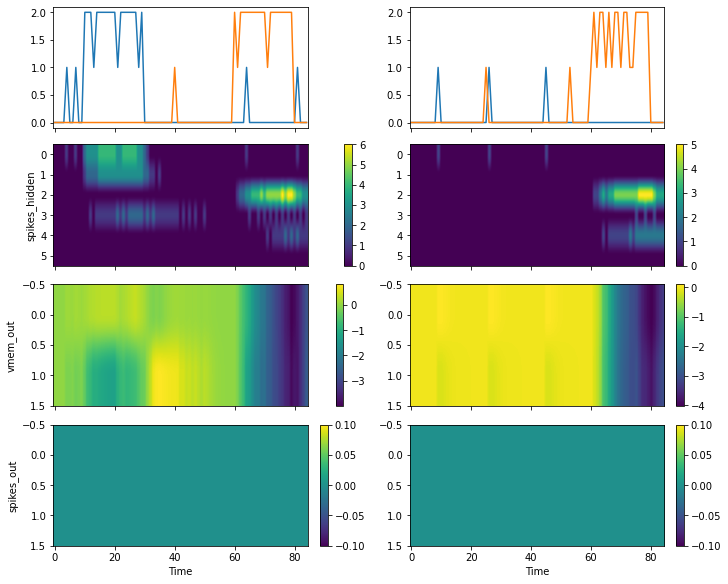

In [11]:
#@title *Solution*
# run one signal type of each class through the model and visualize the 
# input signal, the spikes produced by the neurons in the hidden layer and the
# membrane potential and spikes of the output neurons


# initalize the model
dt = 1e-3
tau_syn_hidden = [2e-3, 4e-3, 8e-3, 16e-3, 32e-3, 64e-3]
snn_untrained = define_SynNet(tau_syn_hidden=tau_syn_hidden, dt=dt)

# lower the threshold of the readout neurons so they can spike
snn_untrained[3].threshold = torch.tensor(1.1)

# process data with model
with torch.no_grad():
  snn_untrained.reset_state()
  _, _,  rec_untrained = snn_untrained(data_test.float(), record=True)

# read out spikes of the hidden layer and membrane potential and spikes of the
# the output neurons from the recording dictionary
spikes_hidden = rec_untrained['1_LIFBitshiftTorch_output'].detach().cpu().numpy()
vmem_out = rec_untrained['3_LIFBitshiftTorch']['vmem'].detach().cpu().numpy()
spikes_out = rec_untrained['3_LIFBitshiftTorch_output'].detach().cpu().numpy()

# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t0][0].item()
batch_idx_c1 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t1][0].item()

# visualize activity in layers
fig, ax = plt.subplots(4, 2, figsize=(10, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].plot(data_test[batch_idx_c1])
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][1].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[1][1])
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[2][0])
img = ax[2][1].imshow(vmem_out[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[2][1])

ax[3][0].set_ylabel('spikes_out')
img = ax[3][0].imshow(spikes_out[batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][0]) 
img = ax[3][1].imshow(spikes_out[batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][1]) 

for i in range(2):  
  ax[3][i].set_xlabel("Time")

plt.show()

# TODO: check that the readout neurons of the model produce spikes if their 
# threshold is lowered
# -> set snn_untrained[3].threshold = torch.tensor(new_threshold)
# why does lowering the spiking threshold also change the membrane potential?

### Train the model

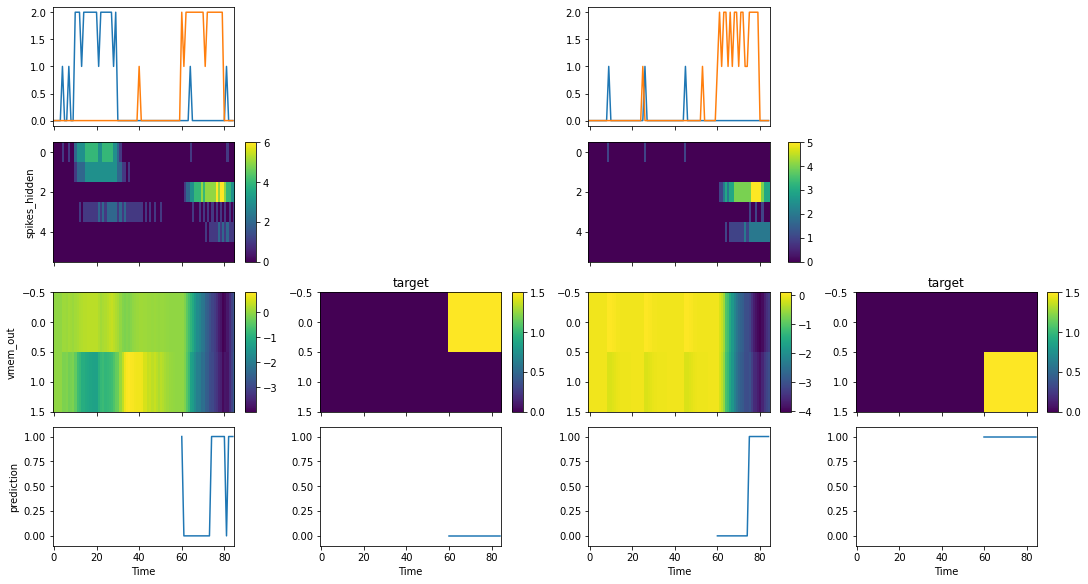

In [12]:
#@title The loss function

# We provide a target function for the membrane potential. This is easier to 
# optimize since the membrane potential is continues while the spikes are
# discontinues and thus give a discontinues loss surface.
# Before onset of the second stimulus the readout neurons should be silent and 
# we set the membrane potential to zero (readout_floor). After presentation of 
# the second pulse the membrane potential of the correct readout neurons is set
# to 1.5 (readout_target) and the other ine remains zero.


def targets_over_time(labels, readout_floor, readout_target):
  '''
        calculates time traces of the labels and targets for the membrane
        potential

        :param labels: torch.Tensor with labels of data set, shape: batch_size x 1
        :param readout_floor: scalar, target value for membrane potential for the
                              wrong readout neuron and for both readout neurons 
                              before the second pulse arrives
        :param readout_target: scalar, target value for membrane potential of the 
                               correct readout neuron after the second pulse arrived
        :return: time trace of labels 
                 (torch.Tensor, shape: batch_size x number of time steps after 
                 beginning of second pulse)
                 list of target values of membrane potential of readout neuron 
                 [targets_before_second_pulse, targets_after_second_pulse]
                 targets_before_second_pulse: (torch.Tensor, shape: batch_size x 
                 number of time steps before beginning of second pulse x n_channels)
                 targets_after_second_pulse: (torch.Tensor, shape: batch_size x 
                 number of time steps after beginning of second pulse x n_channels)

  '''

  time_steps_after_second_pulse = duration_stimulus - t_second_pulse
  labels_over_time = labels.repeat(1, time_steps_after_second_pulse)
  vmem_target_after_stim = torch.nn.functional.one_hot(labels_over_time)
  vmem_target_after_stim = vmem_target_after_stim * readout_target
  vmem_target_after_stim[vmem_target_after_stim == 0] = readout_floor
  vmem_target_before_stim = torch.ones((batch_size, t_second_pulse, n_classes))
  vmem_target_before_stim = vmem_target_before_stim * readout_floor
  vmem_target = [vmem_target_before_stim, vmem_target_after_stim]

  return labels_over_time, vmem_target

# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0
labels_over_time, vmem_target = targets_over_time(labels_test, readout_floor, 
                                                  readout_target)
vmem_target  = torch.cat((vmem_target[0], vmem_target[1]), 1)

# visualize activity in layers
fig, ax = plt.subplots(4, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].axis('off')
ax[0][2].plot(data_test[batch_idx_c1])
ax[0][3].axis('off')
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
ax[1][1].axis('off')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][2].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][2])
ax[1][3].axis('off')
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][0])
ax[2][1].set_title('target')
img = ax[2][1].imshow(vmem_target[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][1])
img = ax[2][2].imshow(vmem_out[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][2])
ax[2][3].set_title('target')
img = ax[2][3].imshow(vmem_target[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][3]) 

ax[3][0].set_ylabel('prediction')
predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
ax[3][0].plot(range(t_second_pulse, duration_stimulus), predictions[batch_idx_c0])
ax[3][1].plot(range(t_second_pulse, duration_stimulus), labels_over_time[batch_idx_c0])
ax[3][2].plot(range(t_second_pulse, duration_stimulus), predictions[batch_idx_c1])
ax[3][3].plot(range(t_second_pulse, duration_stimulus), labels_over_time[batch_idx_c1])

for i in range(4): 
  ax[3][i].set_ylim([-0.1, 1.1]) 
  ax[3][i].set_xlabel("Time")

plt.show()

In [13]:
#@title *Exercise:* training

# TODO: initialize the model
dt = 1e-3
tau_syn_hidden = [2e-3, 4e-3, 8e-3, 16e-3, 32e-3, 64e-3]
# snn = ...

# TODO: use MSE loss 
# criterion = ...

# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0

# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the secodn pulse comes in
alpha_pre_pulse = 0.5

# TODO: use the ADAM optimizer, try a learning rate of 0.005
# optimizer = ...

# TODO: use accuracy as the metric
# metric = ...

num_epochs = 100
val_acc_stop = 0.99  # stop training at this accuracy

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []


# pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
# for epoch in pbar_epoch:
#     training_batch_loss, training_batch_acc = [], []
#     val_batch_loss, val_batch_acc = [], []
#     for data, labels in iter(train_loader):

#         # TODO: get targets for the membrane potentials of the readout neurons
#         labels_over_time, vmem_target = targets_over_time(labels, 
#                                                           readout_floor, 
#                                                           readout_target)
        
#         # reset state of model and optimizer
#         snn.reset_state()
#         optimizer.zero_grad()
        
#         # forward pass
#         # TODO: feed the data into the model and readout the recording 
#         # dictionary
#         # _, _,  rec = ...

#         # read out membrane potential of readout neurons
#         # TODO: readout the membrane potential of the readout neurons
#         # vmem_out = ...

#         # TODO: define the loss function
#         #       1. the membrane potential before t_second_pulse should be 
#         #          vmem_target[0]
#         #       2. the membrane potential after t_second_pulse should be 
#         #          vmem_target[1]
#         #       3. add the two loss terms and weigh the loss before the second
#         #          pulse with alpha_pre_pulse
#         # loss = ...

#         # backward pass
#         loss.backward()
#
#         # update parameters
#         optimizer.step()
#         training_batch_loss.append(loss.item())

#         # accuracy
#         # TODO: get predictions for all time steps after the second pulse from
#         # the membrane potential
#         # predictions = ...

#         # TODO: get acccuracy by evaluating the metric between predictions and 
#         # labels over time
#         acc = metric(predictions, labels_over_time)
#         training_batch_acc.append(acc.item())

#     training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
#     training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
#     # validation
#     with torch.no_grad():
#       batch_loss = []
#       for data, labels in iter(val_loader):

#         # TODO: get targets for the membrane potentials of the readout neurons
#         labels_over_time, vmem_target = targets_over_time(labels, 
#                                                           readout_floor, 
#                                                           readout_target)
#         # reset state of model
#         snn.reset_state()

#         # TODO: feed the data into the model and readout the recording 
#         # dictionary
#         # _, _,  rec = ...
#         # vmem_out = ...

#         # TODO: define the loss function
#         #       1. the membrane potential before t_second_pulse should be 
#         #          vmem_target[0]
#         #       2. the membrane potential after t_second_pulse should be 
#         #          vmem_target[1]
#         #       3. add the two loss terms and weigh the loss before the second
#         #          pulse with alpha_pre_pulse
#         # loss = ...

#         val_batch_loss.append(loss.item())

#         # accuracy
#         # TODO: get predictions for all time steps after the second pulse from
#         # the membrane potential
#         predictions = ...

#         # TODO: get acccuracy by. evaluating the metric between predictions and 
#         # labels over time
#         acc = metric(predictions, labels_over_time)
#         val_batch_acc.append(acc.item())
            
#     val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
#     val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    # pbar_epoch.set_postfix(train_loss=training_losses[-1], 
    #                        val_loss=val_losses[-1], 
    #                        val_acc=val_accs[-1])

    # # stop training once target accuracy is reached
    # if val_accs[-1] >= val_acc_stop:
    #   break



In [14]:
#@title *Solution*

# initalize the model
dt = 1e-3
tau_syn_hidden = [2e-3, 4e-3, 8e-3, 16e-3, 32e-3, 64e-3]
snn = define_SynNet(tau_syn_hidden=tau_syn_hidden, dt=dt)

# initialize loss function
criterion = torch.nn.MSELoss()

# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0

# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the second pulse comes in
alpha_pre_pulse = 0.5

# initialize optimizer
optimizer = torch.optim.Adam(snn.parameters().astorch(), lr=0.0005)

# initialize metric
metric = torchmetrics.Accuracy()

num_epochs = 100
val_acc_stop = 0.99  # stop training at this accuracy 

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    training_batch_loss, training_batch_acc = [], []
    val_batch_loss, val_batch_acc = [], []
    for data, labels in iter(train_loader):

        # targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, readout_floor, 
                                                          readout_target)
        # reset state model and optimizer
        snn.reset_state()
        optimizer.zero_grad()

        # forward pass
        _, _,  rec = snn(data.float(), record=True)

        # membrane potential of readout neurons
        vmem_out = rec['3_LIFBitshiftTorch']['vmem']

        # loss function
        # contribution of membrane potential before onset of second pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        # contribution of membrane potential after onset of second pulse
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        training_batch_loss.append(loss.item())

        # accuracy
        # predictions of labels derived from membrane potential of readout neurons 
        # for all time steps after onset of the second pulse
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)

        training_batch_acc.append(acc.item())

    training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
    training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
    # validation
    with torch.no_grad():
      batch_loss = []
      for data, labels in iter(val_loader):

        # targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, readout_floor, 
                                                          readout_target)
        
        # reset state of model
        snn.reset_state()

        # forward pass
        _, _,  rec = snn(data.float(), record=True) 
        # membrane potential of readout neurons
        vmem_out = rec['3_LIFBitshiftTorch']['vmem']

        # loss function
        # contribution of membrane potential before onset of second pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        # contribution of membrane potential after onset of second pulse
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])

        val_batch_loss.append(loss.item())

        # accuracy
        # predictions of labels derived from membrane potential of readout neurons 
        # for all time steps after onset of the second pulse
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)
        
        val_batch_acc.append(acc.item())
            
    val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
    val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    pbar_epoch.set_postfix(train_loss=training_losses[-1], 
                           val_loss=val_losses[-1], 
                           val_acc=val_accs[-1])
    
    # stop training once target accuracy is reached
    if val_accs[-1] >= val_acc_stop:
      break

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
#@title Exercise: visualize loss function
# TODO: visualize training/validation loss and training/validation accuracy

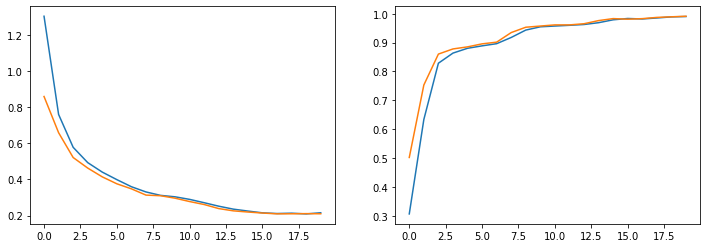

In [16]:
#@title Solution
# plot training/validation loss and training/validation accuracy

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(training_losses)
ax[0].plot(val_losses)
ax[1].plot(training_accs)
ax[1].plot(val_accs)

### Explore the trained model



In [17]:
#@title *Exercise*: visualize activity

# TODO: visualize activity of trained model
# 1. Pass one batch of the test data through the model and visualize spiking 
#    activity of hidden neurons and spikes and membrane potentials of readout 
#    neurons. Pick one sample for each class. Hint: use data_test and labels_test
#    Hint: use visualization of untrained model and add panels for trained model
#    Hint: remember to reset_state() the models before processing data
# 2. lower the threshold of the readout neurons and show how their spiking can
#    be used to classify the input

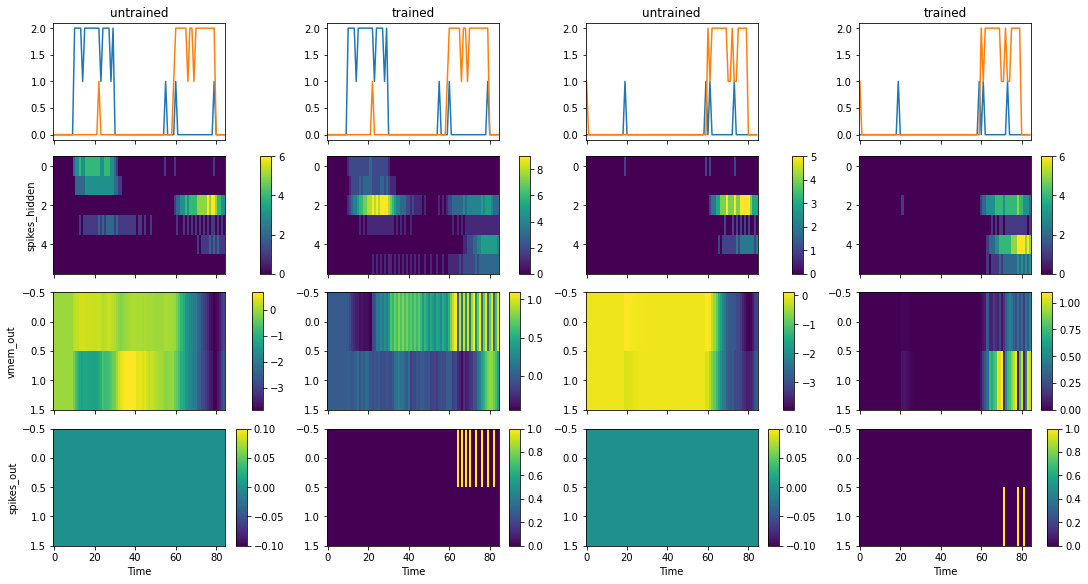

In [18]:
#@title *Solution* 

# visualize activity of trained model

# set threshold of readout neurons to signal class
snn[3].threshold = torch.tensor(1.1)
snn_untrained[3].threshold = torch.tensor(1.1)

# reset state of trained and untrained models and process input samples
with torch.no_grad():
  snn.reset_state()
  _, _,  rec = snn(data_test.float(), record=True)
  snn_untrained.reset_state()
  _, _,  rec_untrained = snn_untrained(data_test.float(), record=True)

# read out spikes of hidden neurons and membrane potential and spikes of 
# readout neurons
spikes_hidden = [rec_untrained['1_LIFBitshiftTorch_output'].detach().cpu().numpy(), 
                 rec['1_LIFBitshiftTorch_output'].detach().cpu().numpy()]
vmem_out = [rec_untrained['3_LIFBitshiftTorch']['vmem'].detach().cpu().numpy(),
            rec['3_LIFBitshiftTorch']['vmem'].detach().cpu().numpy()]
spikes_out = [rec_untrained['3_LIFBitshiftTorch_output'].detach().cpu().numpy(), 
              rec['3_LIFBitshiftTorch_output'].detach().cpu().numpy()]

# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t0][1].item()
batch_idx_c1 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t1][1].item()

fig, ax = plt.subplots(4, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].plot(data_test[batch_idx_c0])
ax[0][2].plot(data_test[batch_idx_c1])
ax[0][3].plot(data_test[batch_idx_c1])
ax[0][0].set_title('untrained')
ax[0][1].set_title('trained')
ax[0][2].set_title('untrained')
ax[0][3].set_title('trained')
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][1].imshow(spikes_hidden[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][1])
img = ax[1][2].imshow(spikes_hidden[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][2])
img = ax[1][3].imshow(spikes_hidden[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][3])
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][0])
img = ax[2][1].imshow(vmem_out[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][1])
img = ax[2][2].imshow(vmem_out[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][2])
img = ax[2][3].imshow(vmem_out[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][3])

ax[3][0].set_ylabel('spikes_out')
img = ax[3][0].imshow(spikes_out[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][0]) 
img = ax[3][1].imshow(spikes_out[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][1])
img = ax[3][2].imshow(spikes_out[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][2]) 
img = ax[3][3].imshow(spikes_out[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][3])

for i in range(4):  
  ax[3][i].set_xlabel("Time")

plt.show()

In [19]:
#@title accuracy function

def get_acc(dataloader, model):
    batch_acc = []
    for data, labels in iter(dataloader):
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        model.reset_state()
        _, _,  rec = model(data.float(), record=True)
        vmem_out = rec['3_LIFBitshiftTorch']['vmem']
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)
        batch_acc.append(acc.item())

    return sum(batch_acc) / len(batch_acc)

In [20]:
#@title *Exercise:* ablation experiments

# test the importance of neurons with different time constants for the accuracy 
# of the model
# -> remove one time constant at a time and create a bar plot with model
#    accuracies
# Hint: neurons do not contribute if their threshold is set high
# Hint: use get_acc() to obtain the accuracy for each model


# set the threshold of output neurons high to get correct accuray for membrane
# potentials
snn[3].threshold = torch.tensor(threshold_readout_for_training)

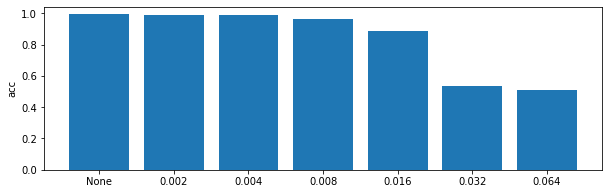

In [21]:
#@title *Solution*

# test the importance of neurons with different time constants for the accuracy 
# of the model by silencing one hidden neurons at a time

# set the threshold of output neurons high to get correct accuracy for membrane
# potentials
snn[3].threshold = torch.tensor(threshold_readout_for_training)

test_accs = []
test_accs.append(get_acc(test_loader, snn))
for i in range(len(tau_syn_hidden)):
    # raise threshold of hidden neuron to silence it
    snn[1].threshold[i] = 100.0  
    # evaluate accuracy for model in one silenced hidden neuron
    test_accs.append(get_acc(test_loader, snn))
    # reset threshold of hidden neuron
    snn[1].threshold[i] = threshold_hidden

# plot accuracies for all ablated models
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(tau_syn_hidden)+1), test_accs)
ax.set_xticks(range(len(tau_syn_hidden)+1))
ax.set_ylabel('removed time constant')
ax.set_ylabel('acc')
ax.set_xticklabels(['None'] + tau_syn_hidden);

### How important are the time constants?

In [22]:
#@title *Exercise* 
# TODO: train a model with the same number of parameters as above but without
# larger time constants (tau_syn=2), check if the networks can still solve the 
# delay task

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

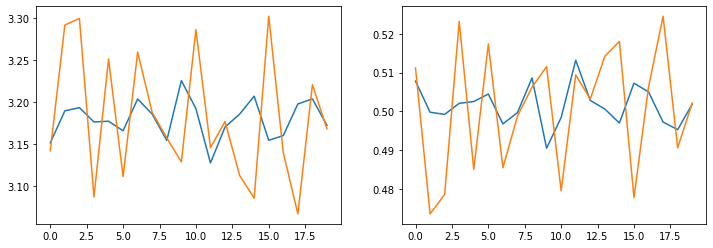

In [23]:
#@title *Solution*

# initialize the model
dt = 1e-3
tau_syn_hidden = [2e-3 for i in range(6)]
snn_small_tau = define_SynNet(tau_syn_hidden=tau_syn_hidden, dt=dt)

# initialize loss function
criterion = torch.nn.MSELoss()

# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0

# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the second pulse comes in
alpha_pre_pulse = 0.5

# initialize optimizer
optimizer = torch.optim.Adam(snn.parameters().astorch(), lr=0.0005)

# initialize metric
metric = torchmetrics.Accuracy()

num_epochs = 20
val_acc_stop = 0.98  # stop training at this accuracy 

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    training_batch_loss, training_batch_acc = [], []
    val_batch_loss, val_batch_acc = [], []
    for data, labels in iter(train_loader):

        # targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, readout_floor, 
                                                          readout_target)
        # reset state model and optimizer
        snn_small_tau.reset_state()
        optimizer.zero_grad()

        # forward pass
        _, _,  rec = snn_small_tau(data.float(), record=True)

        # membrane potential of readout neurons
        vmem_out = rec['3_LIFBitshiftTorch']['vmem']

        # loss function
        # contribution of membrane potential before onset of second pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        # contribution of membrane potential after onset of second pulse
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])

        # backward pass
        loss.backward()

        # update parameters
        optimizer.step()
        training_batch_loss.append(loss.item())

        # accuracy
        # predictions of labels derived from membrane potential of readout neurons 
        # for all time steps after onset of the second pulse
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)

        training_batch_acc.append(acc.item())

    training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
    training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
    # validation
    with torch.no_grad():
      batch_loss = []
      for data, labels in iter(val_loader):

        # targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, readout_floor, 
                                                          readout_target)
        
        # reset state of model
        snn_small_tau.reset_state()

        # forward pass
        _, _,  rec = snn_small_tau(data.float(), record=True) 
        # membrane potential of readout neurons
        vmem_out = rec['3_LIFBitshiftTorch']['vmem']

        # loss function
        # contribution of membrane potential before onset of second pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        # contribution of membrane potential after onset of second pulse
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])

        val_batch_loss.append(loss.item())

        # accuracy
        # predictions of labels derived from membrane potential of readout neurons 
        # for all time steps after onset of the second pulse
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)
        
        val_batch_acc.append(acc.item())
            
    val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
    val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    pbar_epoch.set_postfix(train_loss=training_losses[-1], 
                           val_loss=val_losses[-1], 
                           val_acc=val_accs[-1])
    
    # stop training once target accuracy is reached
    if val_accs[-1] >= val_acc_stop:
      break

# plot loss and accuracy of training and validation set
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(training_losses)
ax[0].plot(val_losses)
ax[1].plot(training_accs)
ax[1].plot(val_accs)

## Deploy SynNet to Xylo

In [24]:
# map model to the xylo architecture

from rockpool.devices import xylo
from rockpool.transform import quantize_methods as q
from rockpool.devices.xylo import config_from_specification
from rockpool.devices.xylo import XyloSim

snn[3].threshold = torch.tensor(threshold_readout_for_training)
g = snn.as_graph()
# Step 1 mapping: create dictionary with ...
spec = xylo.mapper(g, weight_dtype='float', threshold_dtype='float', 
                   dash_dtype='float')

# Step 2 quantization
quant_spec = spec.copy()
# del quant_spec['mapped_graph'] TODO check if necessary
# del quant_spec['dt']
# ...
quant_spec.update(q.global_quantize(**quant_spec))

In [25]:
#@title *Exercise:* visualize quantized parameter
# TODO: 
# - visualize the absolute values of the original and the quantized weights 
#   and convince yourself that the weights are mapped to the correct range
#   Hint: read out the original/quantized weights from spec/quant_spec using 
#         the keys 'weights_in' and. 'weights_out'
# - visualize the original and the quantized weights and show that the 
#   quantization error is not too large

import numpy as np

weights_in: quantization error 1.7242961891758655 %
weights_out: quantization error 0.7346311280647131 %


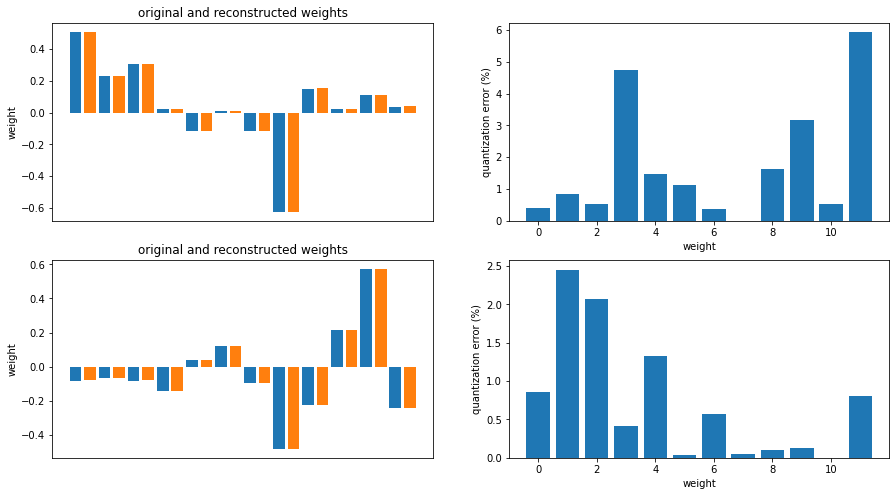

In [26]:
#@title *Solution*

# import numpy as np

# keys = ['weights_in', 'weights_out']
# fig, ax = plt.subplots(ncols=2, nrows=len(keys), figsize=(15, 8))
# for i, key in enumerate(keys):
#     data_original = 127*spec[key].flatten()/np.max(np.abs(spec[key].flatten()))
#     data_quantized = quant_spec[key].flatten()
#     ax[0][i].bar(range(12*2)[::2], data_original);
#     ax[0][i].bar(range(12*2)[1::2], data_quantized);
#     ax[1][i].bar(range(12), data_original-data_quantized);

import numpy as np

keys = ['weights_in', 'weights_out']
fig, ax = plt.subplots(ncols=2, nrows=len(keys), figsize=(15, 8))
for i, key in enumerate(keys):
    data_original = spec[key].flatten()
    data_quantized = quant_spec[key].flatten()
    data_reconstructed = quant_spec[key].flatten() / 127 * np.abs(spec[key].flatten()).max()
    reconstruction_error = (abs(data_original - data_reconstructed) / abs(data_original)).mean() * 100
    print(f"{key}: quantization error {reconstruction_error} %")

    ax[i][0].bar(range(12*2)[::2], data_original);
    ax[i][0].bar(range(12*2)[1::2], data_reconstructed);
    ax[i][0].set_title("original and reconstructed weights")
    ax[i][0].set_ylabel("weight")
    ax[i][0].set_xticks([])

    ax[i][1].bar(range(12), abs(data_original - data_reconstructed) / abs(data_original) * 100);
    ax[i][1].set_ylabel("quantization error (%)")
    ax[i][1].set_xlabel("weight");

In [27]:
# create Xylo configuration from quantized sepecification
xylo_conf, is_valid, message = xylo.config_from_specification(**quant_spec)
print('Valid config: ', is_valid)

# create a XyloSim model
# this model simulates the Xylo chip
# the model can only process one input sample at a time since the chip works 
# in streaming mode
snn_xylo = XyloSim.from_config(xylo_conf, dt=dt)


def get_acc_xylo(dataloader, model):
    metric_xylo = torchmetrics.Accuracy()
    batch_acc = []
    for data, labels in iter(dataloader):
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        for i in range(batch_size):
          model.reset_state()
          _, _, rec = model(data[i].numpy().astype(int), record=True)
          vmem_out = torch.from_numpy(rec['Vmem_out'])
          predictions = vmem_out[t_second_pulse:, :].argmax(1)
          acc = metric_xylo(predictions, labels_over_time[i])
          batch_acc.append(acc.item())

    return sum(batch_acc) / len(batch_acc)

Valid config:  True


In [28]:
#@title *Bonus Exercise:* Evaluate XyloSim model

# TODO: evaluate test accuracy of the XyloSim model and compare
# to the rockpool model
# Hint: use get_acc_xylo() and get_acc()
# print('acc rockpool model', ...)
# print('acc XyloSim model', ...)

# TODO: insert one sample into the XyloSim model and 
# visualize the membrane potential of the readout neurons
# Hint: use the same figure and data samples as for the rockpool model


# TODO: create a XyloSim model with a lower threshold of the
# readout neurons and show that their spikining classifies the
# input correctly
# Hint: change the threshold in quant_spec and create a new XyloSim model

acc rockpool model 0.9920399963855744
acc XyloSim model 0.9560400017499924


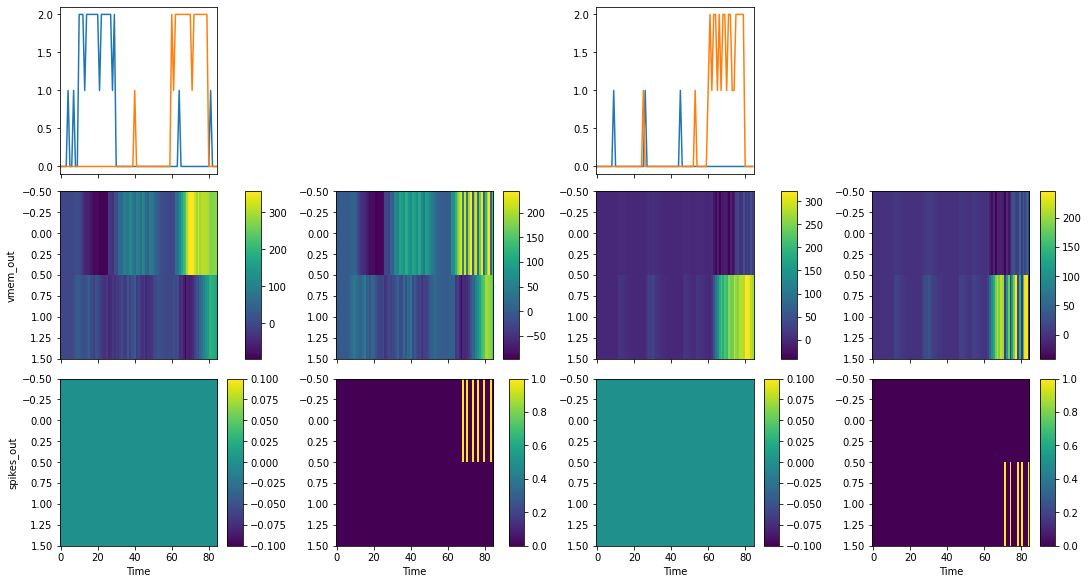

In [29]:
#@title *Solution*

# TODO: evaluate test accuracy of the XyloSim model and compare
# to the rockpool model
# Hint: use get_acc_xylo() and get_acc()
print('acc rockpool model', get_acc(test_loader, snn))
print('acc XyloSim model', get_acc_xylo(test_loader, snn_xylo))

# TODO: insert one sample into the XyloSim model and 
# visualize the membrane potential of the readout neurons

# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t0][0].item()
batch_idx_c1 = torch.arange(0, batch_size, dtype=int)[labels_test[:, 0] == t1][0].item()

snn_xylo.reset_state()
out_xylo_c0, _, rec_xylo_c0 = snn_xylo(data_test[batch_idx_c0].numpy().astype(int), record=True)
vmem_out_xylo_c0 = torch.from_numpy(rec_xylo_c0['Vmem_out'])
snn_xylo.reset_state()
out_xylo_c1, _, rec_xylo_c1 = snn_xylo(data_test[batch_idx_c1].numpy().astype(int), record=True)
vmem_out_xylo_c1 = torch.from_numpy(rec_xylo_c1['Vmem_out'])


# visualize activity in layers
fig, ax = plt.subplots(3, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].axis('off')
ax[0][2].plot(data_test[batch_idx_c1])
ax[0][3].axis('off')
    
ax[1][0].set_ylabel('vmem_out')
img = ax[1][0].imshow(vmem_out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][2].imshow(vmem_out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][2])

ax[2][0].set_ylabel('spikes_out')
img = ax[2][0].imshow(out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][0]) 
img = ax[2][2].imshow(out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][2]) 

for i in range(4):  
  ax[2][i].set_xlabel("Time")


# TODO: create a XyloSim model with a lower threshold of the
# readout neurons and show that their spikining classifies the
# input correctly
# Hint: change the threshold in quant_spec and create a new XyloSim model
quant_spec_low_th = quant_spec.copy()
quant_spec_low_th['threshold_out'] = np.array([250, 250])
xylo_conf, is_valid, message = xylo.config_from_specification(**quant_spec_low_th)
snn_xylo_low_th = XyloSim.from_config(xylo_conf, dt=dt)

snn_xylo_low_th.reset_state()
out_xylo_c0, _, rec_xylo_c0 = snn_xylo_low_th(data_test[batch_idx_c0].numpy().astype(int), record=True)
vmem_out_xylo_c0 = torch.from_numpy(rec_xylo_c0['Vmem_out'])
snn_xylo_low_th.reset_state()
out_xylo_c1, _, rec_xylo_c1 = snn_xylo_low_th(data_test[batch_idx_c1].numpy().astype(int), record=True)
vmem_out_xylo_c1 = torch.from_numpy(rec_xylo_c1['Vmem_out'])

img = ax[1][1].imshow(vmem_out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][1])
img = ax[1][3].imshow(vmem_out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][3])

img = ax[2][1].imshow(out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][1]) 
img = ax[2][3].imshow(out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][3])

plt.show()